In [70]:
import os
from glob import glob
import math
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


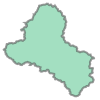

In [99]:
tuolumne = "/Volumes/wrangell-st-elias/research/planet/tuo-head.geojson"
tuolumne = gpd.read_file(tuolumne)
tuolumne.geometry[0]

In [2]:
import geopandas as gpd
import json

In [3]:
%matplotlib inline

In [4]:
from shapely import geometry 

In [5]:
def get_raster_utm_epsg(dataset):
    lon, lat = list(geometry.Polygon.from_bounds(*dataset.bounds).centroid.coords)[0]
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

In [6]:
def label_utm_grid():
    ''' Warning: should only use with small area UTM maps '''
    ax = plt.gca()    
    for val,label in zip(ax.get_xticks(), ax.get_xticklabels()):
        label.set_text(str(val))
        label.set_position((val,0))  

    for val,label in zip(ax.get_yticks(), ax.get_yticklabels()):   
        label.set_text(str(val))
        label.set_position((0,val))  

    plt.tick_params(bottom=True,top=True,left=True,right=True,
            labelbottom=True,labeltop=False,labelleft=True,labelright=False)

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    plt.grid(True)

In [7]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import rasterio as rio

In [8]:
from rasterio.plot import show

In [182]:
root = "/Volumes/wrangell-st-elias/research/planet/tuol-reruns/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180528_181109_1025_3B_AnalyticMS_SR_clip/"

In [183]:
mask_ds = rio.open(glob(os.path.join(root, "mask/*merged*.tif"))[0])
mask_data = mask_ds.read(1, masked=True)

In [184]:
extent = [mask_ds.bounds[0], mask_ds.bounds[2], mask_ds.bounds[1], mask_ds.bounds[3]]
extent

[-119.652099609375, -119.37744140625, 38.09133814927378, 38.19502155795573]

In [185]:
nozero_mask = np.ma.masked_array(mask_data, mask_data == 0)

In [186]:
data_region = gpd.read_file(os.path.join(root, "data-mask.geojson"))

In [187]:
tuolumne.bounds

,minx,miny,maxx,maxy
0,-119.5455,37.739404,-119.199275,38.09415


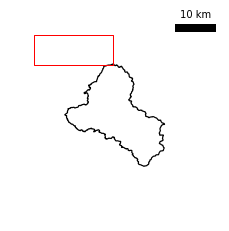

In [227]:
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
ax.margins(2, 2) 
scaling=0.2
ax.add_geometries(tuolumne.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.2)
ax.add_geometries([geometry.Polygon.from_bounds(*(data_region.bounds.values[0]))], crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none')
ax.set_extent([tuolumne.bounds.minx-scaling, tuolumne.bounds.maxx+scaling, tuolumne.bounds.miny-scaling, tuolumne.bounds.maxy+scaling])
ax.outline_patch.set_linewidth(0)
scalebar.scale_bar(ax, (0.8,0.9), 10, linewidth=8, text_offset=0.04)

In [189]:
tuolumne.bounds.values

array([[-119.54550029,   37.7394043 , -119.19927543,   38.09415022]])

In [190]:
def plot_mask(mask, extent, ax, cmap):
    
    im = ax.imshow(mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False

    
def plot_diff(mask, pred, extent, ax):
    diff = mask - pred
    im = ax.imshow(diff, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=-1, vmax=1, cmap='RdBu')
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    return(im)


In [191]:
nodata_diff = geometry.Polygon.from_bounds(*mask_ds.bounds).difference(data_region.geometry.iloc[0])

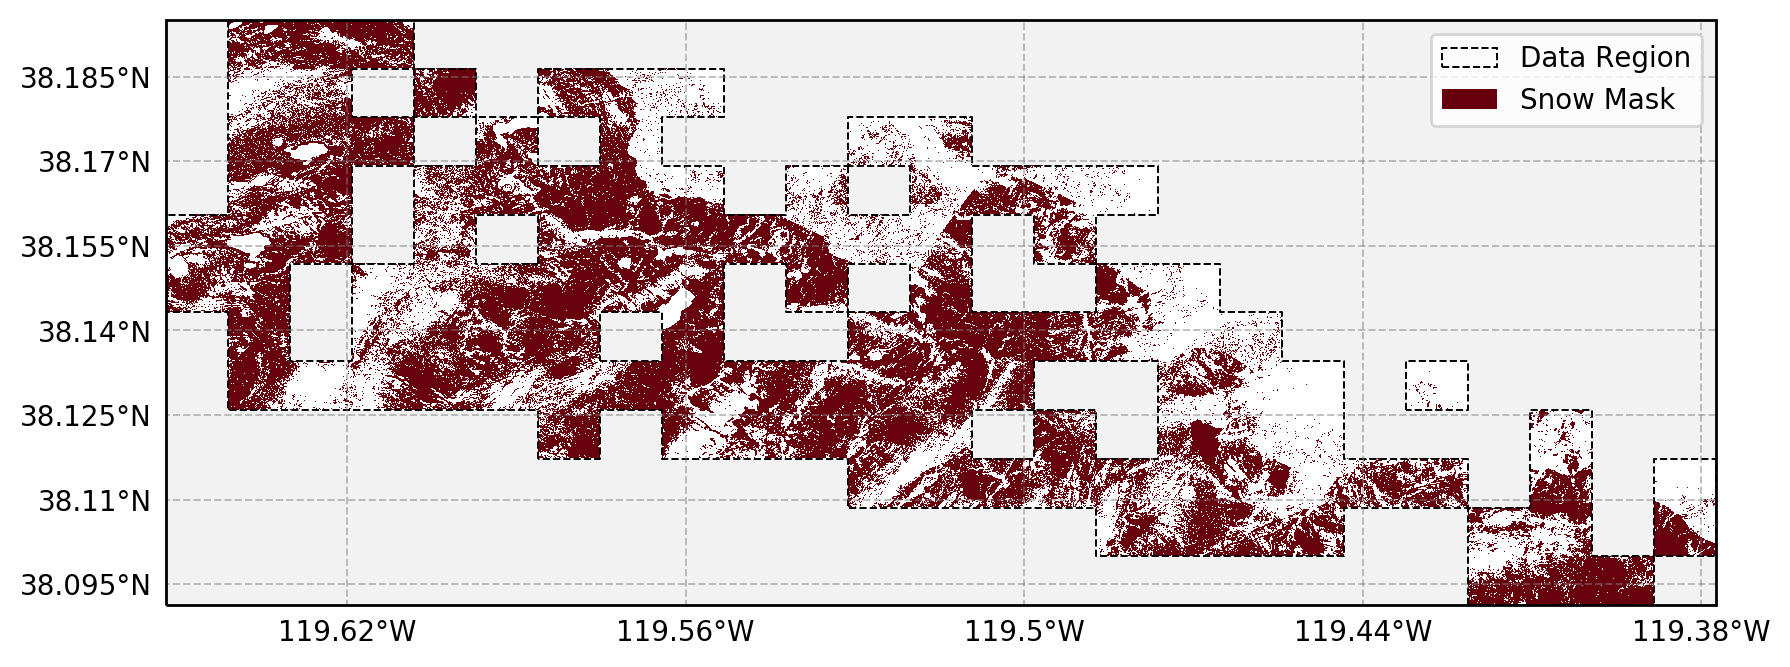

In [192]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap = plt.cm.get_cmap("Reds", 2)
plot_mask(nozero_mask, extent, ax, cmap=cmap)

ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap(1), label='Snow Mask'))
]

ax.legend(handles=legendParts)

# ax.set_extent([-119.59, -119.578, 38.02, 38.035], crs=ccrs.PlateCarree())

In [193]:
pred_ds = rio.open(glob(os.path.join(root, "preds/*merged*.tif"))[0])
pred_data = pred_ds.read(1, masked=True)
nozero_pred = np.ma.masked_array(pred_data, pred_data == 0)

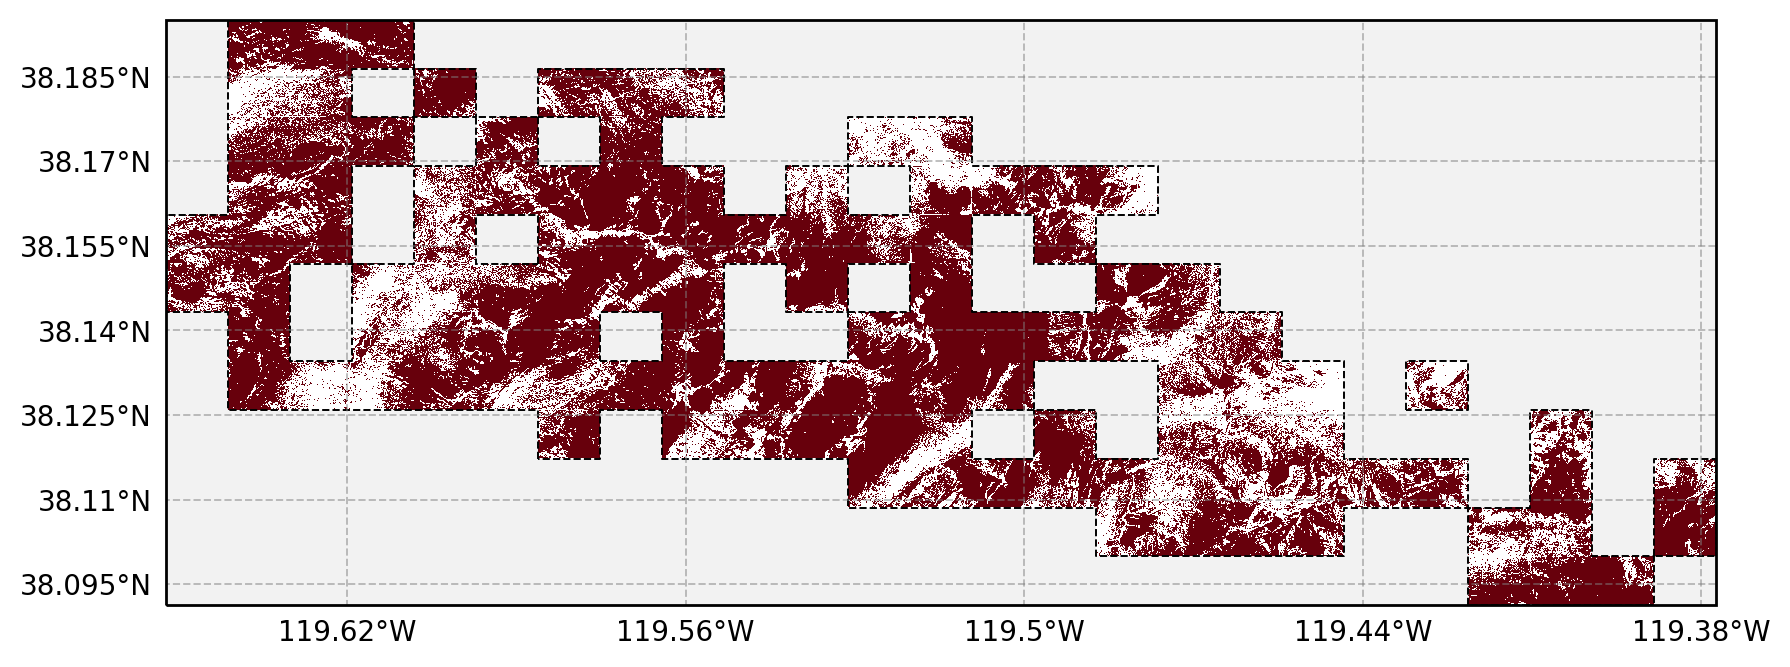

In [194]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
plot_mask(nozero_pred, extent, ax, cmap=cmap)
ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)


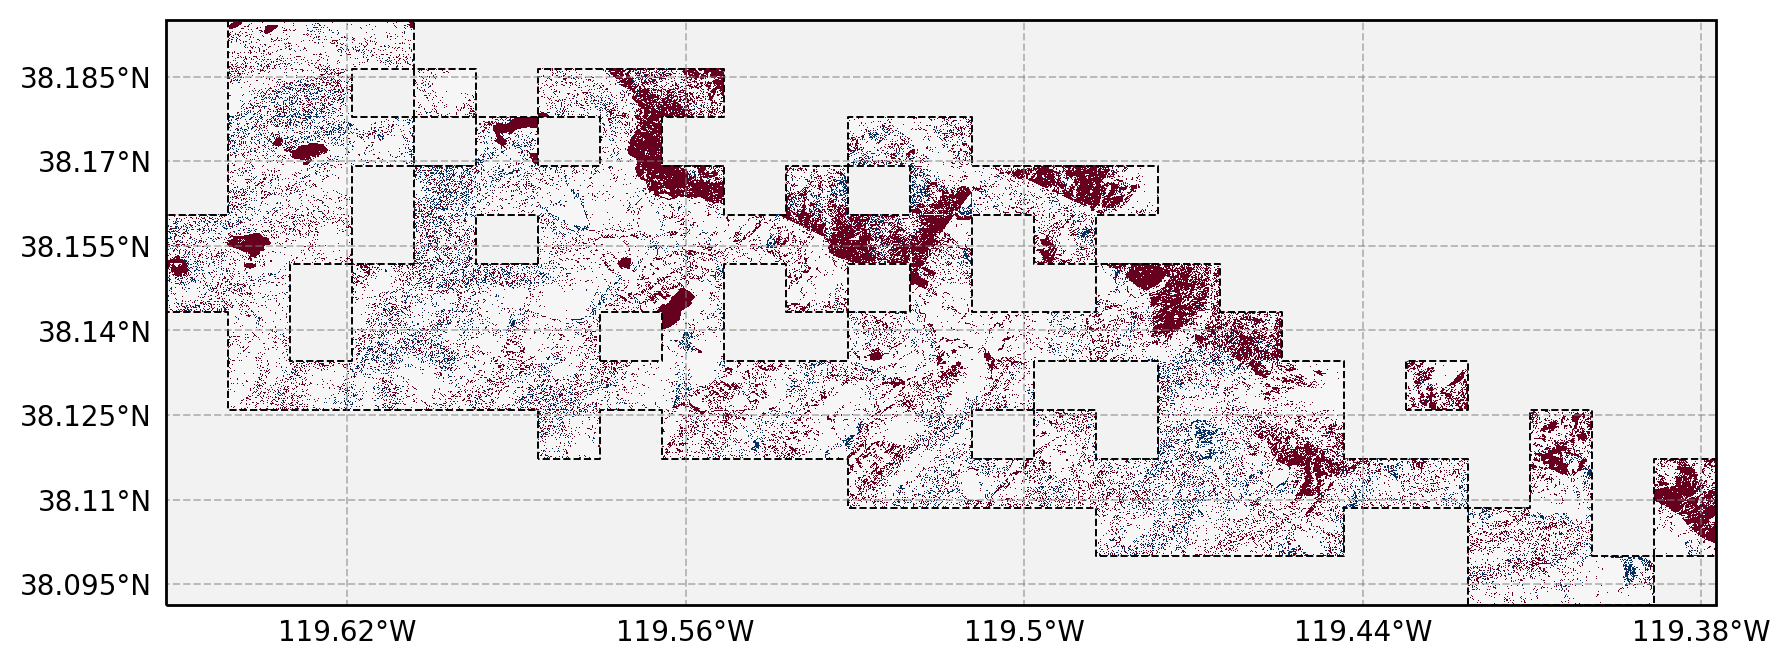

In [195]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
plot_diff(mask_data, pred_data, extent, ax)
ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)


In [196]:
metrics = json.load(open(os.path.join(root, 'aso_metrics.json')))

In [199]:
metrics

{'mask': '/Volumes/wrangell-st-elias/research/planet/tuol-reruns/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180528_181109_1025_3B_AnalyticMS_SR_clip/mask/ASO_3M_SD_USCATE_20180528_binary_merged.tif',
 'preds': '/Volumes/wrangell-st-elias/research/planet/tuol-reruns/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180528_181109_1025_3B_AnalyticMS_SR_clip/preds/20180528_181109_1025_3B_AnalyticMS_SR_clip_merged.tif',
 'metrics': {'balanced_accuracy': 0.764794381269231,
  'precision': 0.7363364154169301,
  'recall': 0.9161723259758147,
  'f_score': 0.8164689596070229}}

In [200]:
metrics.metrics

AttributeError: 'dict' object has no attribute 'metrics'

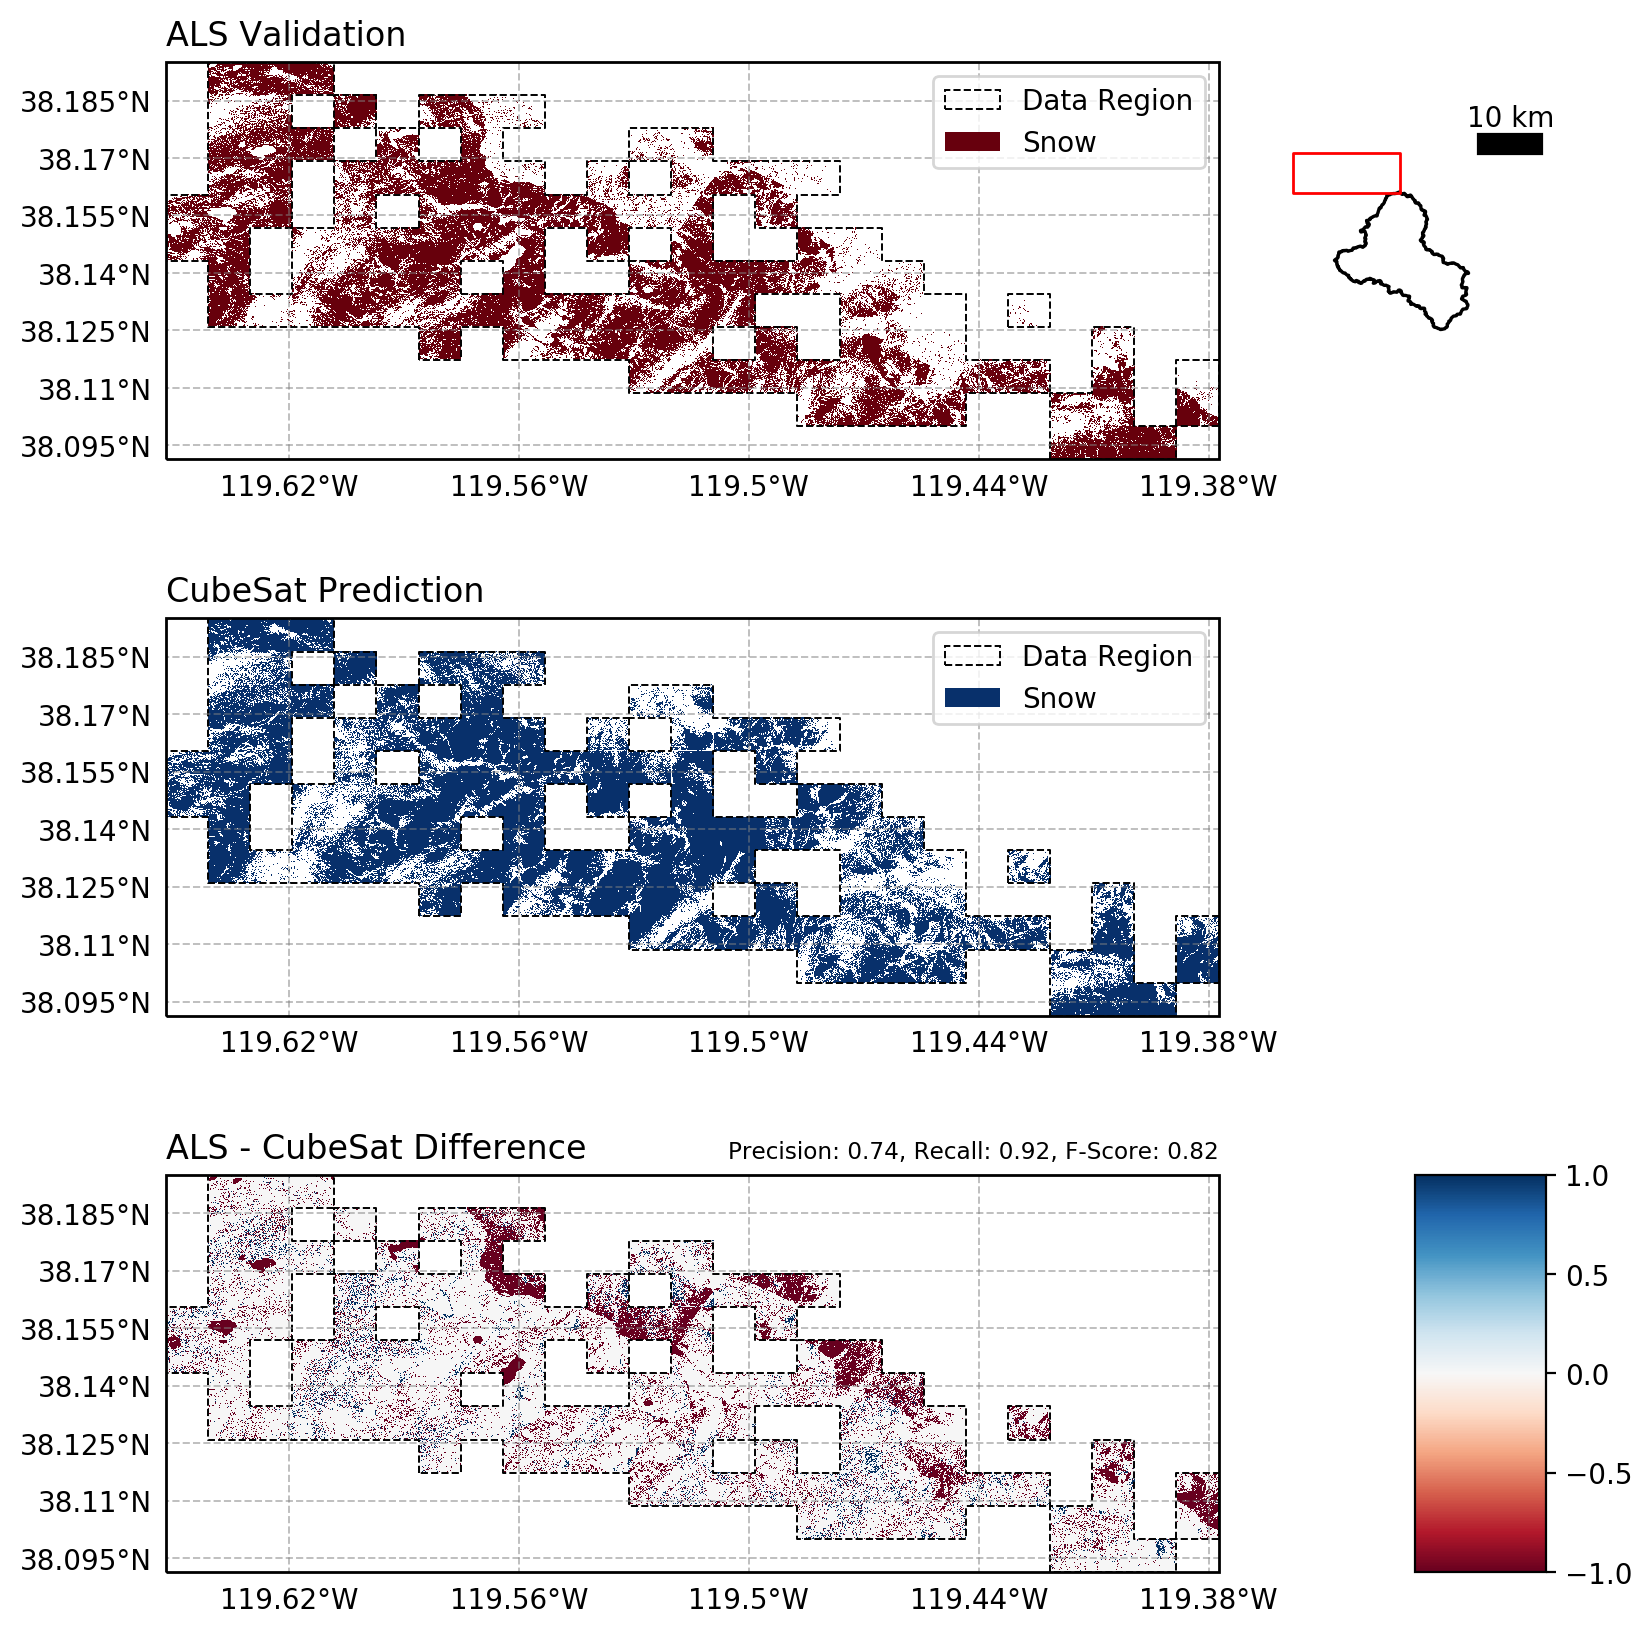

In [228]:
fig = plt.figure(figsize=(10, 10), dpi=200)
gs = fig.add_gridspec(3, 10, hspace=0.4)


mask_ax = fig.add_subplot(gs[0, :7], projection=ccrs.PlateCarree())
# mask_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
mask_cmap = plt.cm.get_cmap("Reds", 2)
plot_mask(nozero_mask, extent, mask_ax, mask_cmap)
mask_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=mask_cmap(1), label='Snow'))
]
mask_ax.set_title("ALS Validation", loc='left')
mask_ax.legend(handles=legendParts)

pred_ax = fig.add_subplot(gs[1, :7], projection=ccrs.PlateCarree())
# pred_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
pred_cmap = plt.cm.get_cmap("Blues", 2)
plot_mask(nozero_pred, extent, pred_ax, pred_cmap)
pred_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=pred_cmap(1), label='Snow'))
]
pred_ax.set_title("CubeSat Prediction", loc='left')
pred_ax.legend(handles=legendParts)

diff_ax = fig.add_subplot(gs[2, :7], projection=ccrs.PlateCarree())
# diff_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
colorable = plot_diff(mask_data, pred_data, extent, diff_ax)
diff_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
diff_ax.set_title("ALS - CubeSat Difference", loc='left')
diff_ax.set_title("Precision: {:.2f}, Recall: {:.2f}, F-Score: {:.2f}".format(metrics['metrics']['precision'], metrics['metrics']['recall'], metrics['metrics']['f_score']),
                  loc='right',
                  fontdict={'fontsize':'small', 'fontweight':'light'})

cbar_ax = fig.add_subplot(gs[2, 8])

locator_ax = fig.add_subplot(gs[0, 7:-1], projection=ccrs.PlateCarree())
scaling=0.2
locator_ax.add_geometries(tuolumne.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.2)
locator_ax.add_geometries([geometry.Polygon.from_bounds(*(data_region.bounds.values[0]))], crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none')
locator_ax.set_extent([tuolumne.bounds.minx-scaling, tuolumne.bounds.maxx+scaling, tuolumne.bounds.miny-scaling, tuolumne.bounds.maxy+scaling])
locator_ax.outline_patch.set_linewidth(0)
scalebar.scale_bar(locator_ax, (0.8,0.9), 10, linewidth=8, text_offset=0.04)


plt.colorbar(colorable, cax=cbar_ax, shrink=0.4)
plt.savefig("test.pdf")

In [206]:
import scalebar